### Project Description: 
Consider the 3-class problem from the previous assignments where predict the type of material (among 3 material types) of a mug based on four measurements, namely the height, diameter, weight, and hue (color). Here we will use Decision Trees to make this prediction. Note that as the data attributes are continuous numbers yo have to use the ≤ attribute and determine a threshold for each node in the tree. As a result you need to solve the information gain for each threshold that is half way between two data points and thus the complexity of the computations increases with the number of data items.

a) Implement a decision tree learner for the full classification problem (using all 4 features and the full data set) that can derive decision trees with an arbitrary, pre-determined depth (up to the maximum depth where all data sets at the leaves are pure) using the information gain criterion.

b) Divide the data set from large training data set and devide into a test set containing the first 6 data items of each material type and a training set containing the remaining data points. Use the resulting training set to derive trees of depths 1 until 8 and evaluate the accuracy of each of the 8 resulting trees for the training samples and for the test set. Compare the classification accuracy on the test set with the one on the training set for each tree depth. For which depths does the result indicate overfitting ?

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import matplotlib.patches as mpatches
# Optional for plotting Decision tree
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text

In [2]:
# Load the data from the separate CSV files
train_data = pd.read_csv("data_train.csv")
test_data = pd.read_csv("data_test.csv")

In [3]:
# Printing train data head
pd.read_csv('data_train.csv').head()

,Height,Diameter,Weight,Hue,Type
0,0.088219,0.105612,0.365148,2.848540,Metal
1,0.080031,0.030000,0.175270,5.704520,Ceramic
2,0.121246,0.113986,0.577712,1.819411,Metal
3,0.127920,0.121948,0.350669,2.452736,Plastic
4,0.079819,0.075180,0.240520,2.479921,Metal


In [4]:
# Printing test data head
pd.read_csv('data_test.csv').head()

,Height,Diameter,Weight,Hue,Type
0,0.121040,0.126502,0.343961,4.350362,Plastic
1,0.167861,0.150000,0.593048,2.964762,Plastic
2,0.076760,0.030000,0.112163,3.814482,Metal
3,0.169580,0.144642,0.517608,3.360588,Plastic
4,0.093277,0.088731,0.360680,2.935963,Metal


In [5]:
# Split the training data into features and labels
X_train = train_data.drop("Type", axis=1)
y_train = train_data["Type"]

# The test data only has features
X_test = test_data.drop("Type", axis=1)
y_test = test_data["Type"]

train_accuracies = []
test_accuracies = []

In [6]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None
class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=100, n_feats=None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_feats = n_feats
        self.root = None

    def fit(self, X, y):
        self.n_feats = X.shape[1] if not self.n_feats else min(self.n_feats, X.shape[1])
        self.root = self._grow_tree(X, y)

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        if depth >= self.max_depth or n_labels == 1 or n_samples < self.min_samples_split:
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_features, self.n_feats, replace=False)

        best_feat, best_thresh = self._best_criteria(X, y, feat_idxs)
        left_idxs, right_idxs = self._split(X[:, best_feat], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth+1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth+1)
        return Node(best_feat, best_thresh, left, right)

    def _best_criteria(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_thresh = None, None
        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)
            for threshold in thresholds:
                gain = self._information_gain(y, X_column, threshold)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_thresh = threshold

        return split_idx, split_thresh

    def _information_gain(self, y, X_column, split_thresh):
        parent_entropy = self._entropy(y)

        left_idxs, right_idxs = self._split(X_column, split_thresh)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0

        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = self._entropy(y[left_idxs]), self._entropy(y[right_idxs])
        child_entropy = (n_l / n) * e_l + (n_r / n) * e_r
        ig = parent_entropy - child_entropy
        return ig

    def _entropy(self, y):
        _, counts = np.unique(y, return_counts=True)
        probabilities = counts / len(y)
        entropy = sum(-p * np.log2(p) for p in probabilities)
        return entropy

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

    def _most_common_label(self, y):
        counter = Counter(y)
        most_common = counter.most_common(1)[0][0]
        return most_common

In [7]:
def accuracy(y_true, y_pred):
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    return accuracy

In [8]:
def create_and_test_decision_tree(depth, X_test, y_test):
    clf = DecisionTree(max_depth=depth)
    clf.fit(X_train.values, y_train.values)
    y_pred_train = clf.predict(X_train.values)
    train_accuracy = accuracy(y_train.values, y_pred_train)
    y_pred_test = clf.predict(X_test.values)
    test_accuracy = accuracy(y_test.values, y_pred_test)
    return train_accuracy, test_accuracy, y_pred_test, clf

In [9]:
max_pure_depth = 1
while True:
    train_accuracy, _, _, _ = create_and_test_decision_tree(max_pure_depth, X_test, y_test)
    if train_accuracy == 1.0:
        break
    max_pure_depth += 1

In [10]:
print(f"Maximum depth where all leaves are pure: {max_pure_depth}")

Maximum depth where all leaves are pure: 7


In [11]:
train_accuracy, _, y_pred_test, _ = create_and_test_decision_tree(max_pure_depth, X_test, y_test)
print(f"Test predictions: {y_pred_test}")

Test predictions: ['Metal' 'Plastic' 'Metal' 'Plastic' 'Metal' 'Metal']


In [12]:
for depth in range(1, 9):
    train_accuracy, test_accuracy, y_pred_test, _ = create_and_test_decision_tree(depth, X_test, y_test)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    print(f"Depth: {depth}, Train accuracy: {train_accuracy:.2f}, Test accuracy: {test_accuracy:.2f}, Test predictions: {y_pred_test}")

Depth: 1, Train accuracy: 0.64, Test accuracy: 0.33, Test predictions: ['Ceramic' 'Plastic' 'Ceramic' 'Plastic' 'Ceramic' 'Ceramic']
Depth: 2, Train accuracy: 0.73, Test accuracy: 0.67, Test predictions: ['Ceramic' 'Plastic' 'Metal' 'Plastic' 'Ceramic' 'Metal']
Depth: 3, Train accuracy: 0.80, Test accuracy: 0.67, Test predictions: ['Ceramic' 'Plastic' 'Metal' 'Plastic' 'Ceramic' 'Metal']
Depth: 4, Train accuracy: 0.86, Test accuracy: 0.50, Test predictions: ['Metal' 'Plastic' 'Ceramic' 'Plastic' 'Ceramic' 'Metal']
Depth: 5, Train accuracy: 0.93, Test accuracy: 0.67, Test predictions: ['Metal' 'Plastic' 'Metal' 'Plastic' 'Ceramic' 'Metal']
Depth: 6, Train accuracy: 0.96, Test accuracy: 0.83, Test predictions: ['Metal' 'Plastic' 'Metal' 'Plastic' 'Metal' 'Metal']
Depth: 7, Train accuracy: 1.00, Test accuracy: 0.83, Test predictions: ['Metal' 'Plastic' 'Metal' 'Plastic' 'Metal' 'Metal']
Depth: 8, Train accuracy: 1.00, Test accuracy: 0.83, Test predictions: ['Metal' 'Plastic' 'Metal' 'Plas

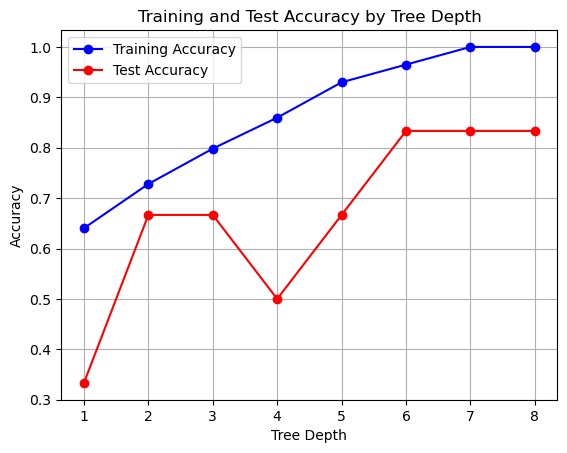

In [13]:
depths = list(range(1, 9))
plt.plot(depths, train_accuracies, 'o-', color='blue', label='Training Accuracy')
plt.plot(depths, test_accuracies, 'o-', color='red', label='Test Accuracy')

plt.xlabel('Tree Depth')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy by Tree Depth')
plt.legend()
plt.grid()
plt.show()

From the plot we can say that, system is overfitting for depth > 4

### Optional Section (ploting decision tree)

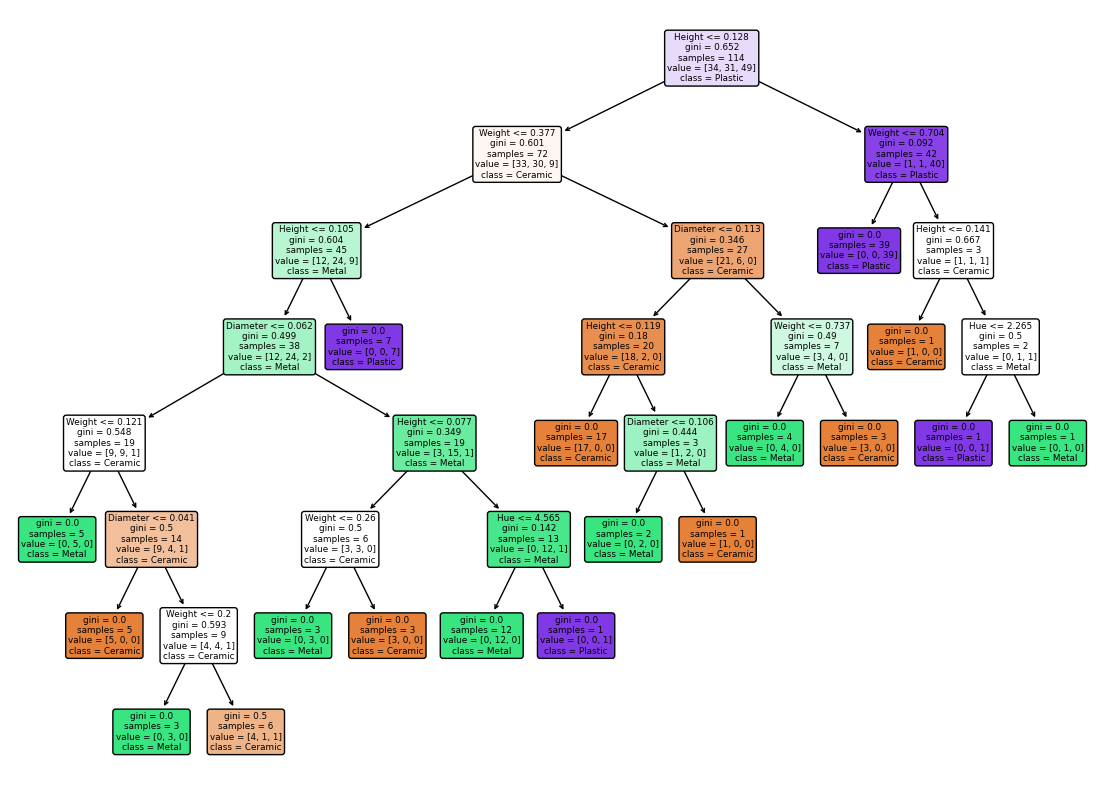

In [15]:
# Optional section for plotting Decison tree
# Train the decision tree using the sklearn library
clf_sklearn = DecisionTreeClassifier(max_depth=max_pure_depth, random_state=42)
clf_sklearn.fit(X_train, y_train)

# Visualize the tree using sklearn's plot_tree function
plt.figure(figsize=(14, 10))
plot_tree(clf_sklearn, filled=True, feature_names=X_train.columns, class_names=clf_sklearn.classes_, rounded=True)
plt.show()